In [50]:
!pip install kornia
import os
import torch
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torchsummary import summary
import timeit
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from skimage.transform import rescale, resize, downscale_local_mean
import kornia
height = int(480/2)
width = int(640/2)

'''Creates Random tensor that is the same size as the image (for testing)'''
def imageBatch(nb_image):
    imgBatch = torch.rand(nb_image, 3, width, height)
    return imgBatch

'''Creates Random tensor that is the same size as the depthmap (for testing)'''
def depthBatch(nb_image):
    depthBatch = torch.rand(nb_image, width*height, 1, 1)
    return depthBatch

def normalize(imageBatch):
    for i in range(len(imageBatch)):
      imageBatch[i] = preprocessing.normalize(imageBatch[i], norm='l2', axis=1, copy=True, return_norm=False)
    return imageBatch

'''CNN doing the first stage of the Semi-Siamese Network (forms the two 'heads')'''
def firstStageCNN():
    return nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, stride=2),  # optional: add stride
                         nn.ReLU(inplace=True),
                         nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1),

                         nn.Conv2d(32, 62, kernel_size=3, stride=2),
                         nn.ReLU(inplace=True),
                         nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1),
                         nn.MaxPool2d(kernel_size=3),  # optional: add stride
                         nn.ReLU(inplace=True),

                         nn.Conv2d(62, 92, kernel_size=3, stride=2),  # optional: add stride
                         nn.ReLU(inplace=True),
                         nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=1),

                         nn.MaxPool2d(kernel_size=3),  # optional: add stride
                         nn.ReLU(inplace=True))

'''Form the complete network by taking the two heads and connecting them to
the body'''
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn1 = firstStageCNN()

        self.cnn2 = firstStageCNN()

        self.fc = nn.Sequential(nn.Conv2d(2208, 92, kernel_size=1),
                                nn.ReLU(inplace=True),

                                nn.Upsample(scale_factor=2, mode='nearest'),
                                nn.ReLU(inplace=True),

                                nn.Conv2d(92, 62, kernel_size=1),
                                nn.ReLU(inplace=True),

                                nn.Upsample(scale_factor=2, mode='nearest'),
                                nn.ReLU(inplace=True),

                                nn.Conv2d(62, 32, kernel_size=4),
                                nn.ReLU(inplace=True),

                                nn.Conv2d(32, width*height, kernel_size=1),
                                nn.ReLU(inplace=True),
                                nn.Softmax2d()
                                )

    '''forwards through the first CNNs to the Main body then returns the output'''
    def forward(self, input1, input2):
        output1 = self.cnn1(input1)
        output2 = self.cnn2(input2)

        combined = torch.cat((output1.view(output1.size(0), -1),
                              output2.view(output2.size(0), -1)), dim=1)

        combined = torch.unsqueeze(combined, 2)
        combined = torch.unsqueeze(combined, 3)
        out = self.fc(combined)
        return out

''' Does the training of the whole dataset'''
def train(net, training_DATA_LEFT, training_DATA_RIGHT, depthMaps, EPOCHS, BATCH_SIZE):
    optimizer = optim.Adam(net.parameters(), lr=0.005)
    loss_function = kornia.losses.SSIM(11, reduction='mean')
    dataset = utils.TensorDataset(training_DATA_LEFT, training_DATA_RIGHT, depthMaps)
    train_dataloader = DataLoader(dataset, shuffle=True, num_workers=0, batch_size=1)
    net.zero_grad()
    COUNTER = 1
    avg_loss = []
    print("train function was executed")
    for epoch in range(EPOCHS):
        for i, data in enumerate(train_dataloader):

            img1, img2, depthmap = data
            optimizer.zero_grad() # reset gradient
            outputs = net(img1, img2)
            loss = loss_function(depthmap, outputs)
            print("Loss:", float(loss))
            avg_loss.append(loss.detach())

            loss.backward()
            optimizer.step()
        #Print out images and epoch numbers 
        print("Epoch number: ", COUNTER)
        COUNTER += 1 
        avg_loss = np.array(avg_loss)
        print("Average Loss:", np.mean(avg_loss))
        avg_loss = []
        plt.figure()
        plt.imshow((outputs.view(height,width)).detach().numpy())
        # plt.show()
        plt.figure()
        plt.imshow((depthmap.view(height,width)).detach().numpy())
        # plt.show
        image = img1.view(3,height,width)
        plt.figure()
        plt.imshow(np.swapaxes(np.swapaxes(image.detach().numpy(),0,2),0,1))
        plt.show()
        outputs = net(img1, img2)
        img1 = img1.view(3,height,width)
        img2 = img2.view(3,height,width)

        plt.figure()
        plt.imshow((outputs.view(height,width)).detach().numpy())
        plt.figure()
        plt.imshow((depthmap.view(height,width)).detach().numpy())
        plt.figure()
        plt.imshow(np.swapaxes(np.swapaxes(img1.detach().numpy(),0,2),0,1))
      
    return net
def rescale_img(imageL, imageR, depthMap):
  resizedL = []
  resizedR = []
  resizedDepth = []
  for img in imageL:
    resizedL.append(rescale(img, (1,0.5,0.5), anti_aliasing=True))
  for img in imageR:
    resizedR.append(rescale(img, (1,0.5,0.5), anti_aliasing=True))
  for img in depthMap:
    resizedDepth.append(rescale(img, 0.5, anti_aliasing=True))
  return np.array(resizedL), np.array(resizedR), np.array(resizedDepth)



train function was executed
Loss: 0.13535356521606445
Loss: 0.13894186913967133
Loss: 0.13936923444271088
Loss: 0.12896212935447693
Loss: 0.13654327392578125
Loss: 0.13918673992156982
Loss: 0.145579531788826
Loss: 0.1427236944437027
Loss: 0.13887028396129608
Loss: 0.12133549898862839
Loss: 0.13888123631477356
Loss: 0.13779333233833313
Loss: 0.12287915498018265
Loss: 0.14253473281860352
Loss: 0.12907104194164276
Loss: 0.14336255192756653
Loss: 0.14237135648727417
Loss: 0.12715347111225128
Loss: 0.1348508596420288
Loss: 0.1453828364610672
Loss: 0.13701790571212769
Loss: 0.138543039560318
Loss: 0.13560974597930908
Loss: 0.13564236462116241
Loss: 0.13978415727615356
Loss: 0.13663531839847565
Loss: 0.13441379368305206
Loss: 0.14102450013160706
Loss: 0.14027445018291473
Loss: 0.14051632583141327
Loss: 0.14048051834106445
Loss: 0.14626258611679077
Loss: 0.14452998340129852
Loss: 0.13128452003002167
Loss: 0.13764575123786926
Loss: 0.14147059619426727
Loss: 0.13794459402561188
Loss: 0.142259135

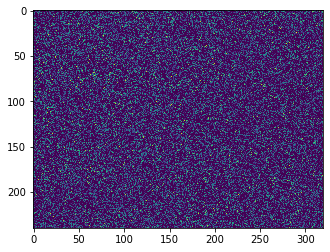

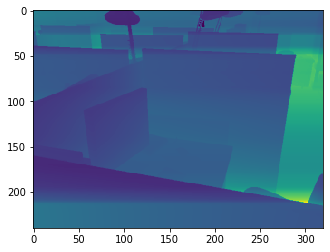

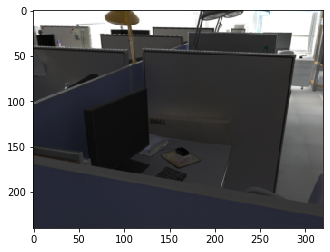

Loss: 0.14336258172988892
Loss: 0.1441352218389511
Loss: 0.13894186913967133
Loss: 0.117677241563797
Loss: 0.14456553757190704
Loss: 0.1433544158935547
Loss: 0.14253473281860352
Loss: 0.13615384697914124
Loss: 0.1388702690601349
Loss: 0.14276395738124847
Loss: 0.12715347111225128
Loss: 0.14275093376636505
Loss: 0.12694445252418518
Loss: 0.14626258611679077
Loss: 0.1348857432603836
Loss: 0.13654495775699615
Loss: 0.1461024284362793
Loss: 0.1398768126964569
Loss: 0.13796301186084747
Loss: 0.13843238353729248
Loss: 0.14648626744747162
Loss: 0.13820287585258484
Loss: 0.1265350580215454
Loss: 0.13854052126407623
Loss: 0.14189742505550385
Loss: 0.14205199480056763
Loss: 0.14481203258037567
Loss: 0.13432104885578156
Loss: 0.139072448015213
Loss: 0.14297841489315033
Loss: 0.14102450013160706
Loss: 0.14123527705669403
Loss: 0.14012543857097626
Loss: 0.14087039232254028
Loss: 0.13535353541374207
Loss: 0.13574600219726562
Loss: 0.1392495483160019
Loss: 0.14302371442317963
Loss: 0.1381163001060485

In [0]:
def main():
    height = 240
    width = 320
    net = SiameseNetwork()
    #This will import the real dataset in tensor arrays once the data is available
    training_DATA_LEFT = np.load('test_daylight_left.npy')
    training_DATA_RIGHT = np.load('test_daylight_right.npy')
    depthMaps = np.load('test_depthmap_left.npy')
    # training_DATA_LEFT = np.swapaxes(training_DATA_LEFT,1,3)
    # training_DATA_RIGHT = np.swapaxes(training_DATA_RIGHT,1,3)
    training_DATA_LEFT, training_DATA_RIGHT, depthMaps = rescale_img(training_DATA_LEFT, training_DATA_RIGHT, depthMaps)
    depthMaps = normalize(depthMaps)

    training_DATA_LEFT = torch.from_numpy(training_DATA_LEFT)
    training_DATA_RIGHT = torch.from_numpy(training_DATA_RIGHT)
    depthMaps = torch.from_numpy(depthMaps)
    # reshape output
    depthMaps = depthMaps.view(-1,int(width*height),1,1)
    network = final = train(net, training_DATA_LEFT, training_DATA_RIGHT, depthMaps, EPOCHS = 15, BATCH_SIZE = 5)
    torch.save(network, 'saved_network')

if __name__ == '__main__':
    main()


In [3]:
drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls "/content/drive/My Drive"

In [0]:
!cp "/content/drive/My Drive/Sample test data/test_daylight_left.npy" "test_daylight_left.npy"
!cp "/content/drive/My Drive/Sample test data/test_daylight_right.npy" "test_daylight_right.npy"
!cp "/content/drive/My Drive/Sample test data/test_depthmap_left.npy" "test_depthmap_left.npy"

torch.Size([180, 480, 640, 3])


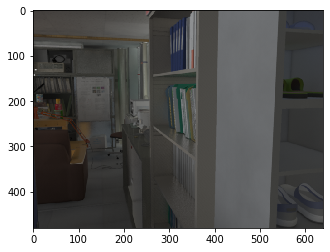

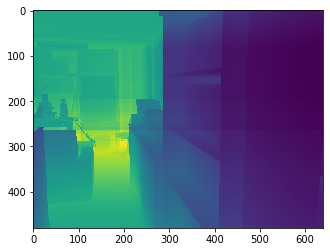

In [0]:
 #This will import the real dataset in tensor arrays once the data is available
training_DATA_LEFT = np.load('test_daylight_left.npy')
training_DATA_RIGHT = np.load('test_daylight_right.npy')
depthMaps = np.load('test_depthmap_left.npy')
depthMaps = normalize(depthMaps)
# training_DATA_LEFT = np.swapaxes(training_DATA_LEFT,1,3)
training_DATA_RIGHT = np.swapaxes(training_DATA_RIGHT,1,3)
training_DATA_RIGHT = np.swapaxes(training_DATA_RIGHT,1,2)

training_DATA_LEFT = torch.from_numpy(training_DATA_LEFT)
training_DATA_RIGHT = torch.from_numpy(training_DATA_RIGHT)
depthMaps = torch.from_numpy(depthMaps)

print(training_DATA_RIGHT.shape)
# reshape output
# depthMaps = depthMaps.view(-1,width*height,1,1)
plt.figure()
plt.imshow((training_DATA_RIGHT[126].detach().numpy()))
plt.show()
plt.figure()
plt.imshow(depthMaps[126].detach().numpy())
plt.show()